In [2]:
cd ..

/Users/lisawink/Documents/freiburg


In [40]:
import geopandas as gpd
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import calc_params
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
temp =  pd.read_csv('/Users/lisawink/Documents/paper1/data/gap_filled_data_ta_rh.csv')
temp['datetime_UTC']=pd.to_datetime(temp['datetime_UTC'])
temp = temp[temp['variable']=='Ta_deg_C']
temp['datetime_UTC'] = temp['datetime_UTC'].astype(str)
temp = temp.pivot(index='station_id', columns='datetime_UTC', values='value')

In [5]:
hiwn = pd.read_csv('/Users/lisawink/Documents/paper1/data/processed_data/heat_island_winter_nights.csv')

In [8]:
# Define station IDs
stations = ['FRASHA', 'FRBETZ', 'FRBRUH', 'FRDREI', 'FRFRIE', 'FRGART', 'FRGLBA',
            'FRGUNT', 'FRHAID', 'FRHBHF', 'FRHERD', 'FRHOLZ', 'FRIHOC', 'FRINST',
            'FRKART', 'FRLAND', 'FRLORE', 'FRMESS', 'FROWIE', 'FRPDAS', 'FRRIES',
            'FRSEEP', 'FRSTGA', 'FRSTGE', 'FRSTUH', 'FRUNIK', 'FRUWIE', 'FRVAUB',
            'FRWEIN', 'FRWSEE', 'FRZAHR']

# Create a colormap (e.g., using the 'tab20' color palette)
cmap = plt.get_cmap('tab20', len(stations))  # 31 unique colors
station_colors = {station: cmap(i) for i, station in enumerate(stations)}  # Map station to color


In [9]:
def plot(ax, radius, param, time):
    vars = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{radius}.parquet')
    vars.index = vars['station_id']
    to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
    vars = vars.drop(to_remove, axis=1)
    vars = vars.merge(temp, left_on='station_id', right_on='station_id',how='inner')

    scaler = StandardScaler()
    vars_scaled = scaler.fit_transform(vars)
    vars = pd.DataFrame(vars_scaled, columns=vars.columns, index=vars.index)

    var = param

    data = vars[[var, time]].copy()

    for t in time.values:
        colors = [station_colors[station] for station in vars.index]  # Assign colors to each station
        ax.scatter(vars[var], vars[t], marker ='x', c=colors, alpha =0.5)
    ax.set_xlabel(var,fontsize=16)
    ax.set_ylabel('Temperature',fontsize=16)
    #ax.set_title(var+' vs Temperature'+' for '+str(radius)+'m radius')

    for i, txt in enumerate(vars.index):
        ax.annotate(txt, (vars[var].iloc[i], vars[time.loc[0]].iloc[i]), color=station_colors[txt])


In [52]:
def stats_multiple_times(radius, var, time):
    vars = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{radius}.parquet')
    vars.index = vars['station_id']
    to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
    vars = vars.drop(to_remove, axis=1)
    vars = vars.merge(temp, left_on='station_id', right_on='station_id',how='inner')

    scaler = StandardScaler()
    vars_scaled = scaler.fit_transform(vars)
    vars = pd.DataFrame(vars_scaled, columns=vars.columns, index=vars.index)

    data = vars[[var] + list(hiwn.values.flatten())].copy().reset_index()
    data = data.melt(id_vars=[var,'station_id'], value_vars=hiwn.values.flatten(), var_name='time', value_name='temperature')
    data = data.dropna()

    # Compute Spearman correlation
    spearman_corr, p_value = spearmanr(data[var], data['temperature'])

    #Pearson and r squared
    pearson_corr, _ = pearsonr(data[var], data['temperature'])
    X = sm.add_constant(data[var])  # Add constant for regression
    model = sm.OLS(data['temperature'], X).fit()
    r_squared = model.rsquared

    # Get the predicted values (fitted values)
    y_pred = model.fittedvalues

    # Calculate the residuals (errors)
    residuals = data['temperature'] - y_pred

    # Calculate the least squares error (RSS)
    rss = np.sum(residuals ** 2)
    # Calculate the Mean Squared Error (MSE)
    mse = rss / len(data[var])
    # Calculate the Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Compute Cook's distance
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0].max()  # Max Cook's distance

    return data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred

In [53]:
def plot2(ax, radius, var, time):

    data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)

    # Add textbox with correlation and Cook’s distance
    textstr = f"Pearson r2: {r_squared:.3f}\nRMSE: {rmse:.3f}\nSpearman ρ: {spearman_corr:.2f}\nMax Cook's D: {cooks_d:.3f}"
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    colors = [station_colors[station] for station in data['station_id']]  # Assign colors to each station
    ax.scatter(data[var], data['temperature'], marker ='x', c=colors, alpha =0.5)
    ax.plot(data[var], y_pred, color='black', linewidth=1)  # Plot regression
    ax.set_xlabel(var,fontsize=16)
    ax.set_ylabel('Temperature',fontsize=16)
    #ax.set_title(var+' vs Temperature'+' for '+str(radius)+'m radius')

    for i, txt in enumerate(data['station_id'][:30]):
        ax.annotate(txt, (data[var].iloc[i], data['temperature'].iloc[i]), color=station_colors[txt])

In [24]:
vars = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_200.parquet')
vars.index = vars['station_id']
to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
vars = vars.drop(to_remove, axis=1)
vars = vars.merge(temp, left_on='station_id', right_on='station_id',how='inner')

scaler = StandardScaler()
vars_scaled = scaler.fit_transform(vars)
vars = pd.DataFrame(vars_scaled, columns=vars.columns, index=vars.index)

var = 'StrHW_median'

data = vars[[var] + list(hiwn.values.flatten())].copy().reset_index()

/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


# Add Spearman Correlation

/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/skle

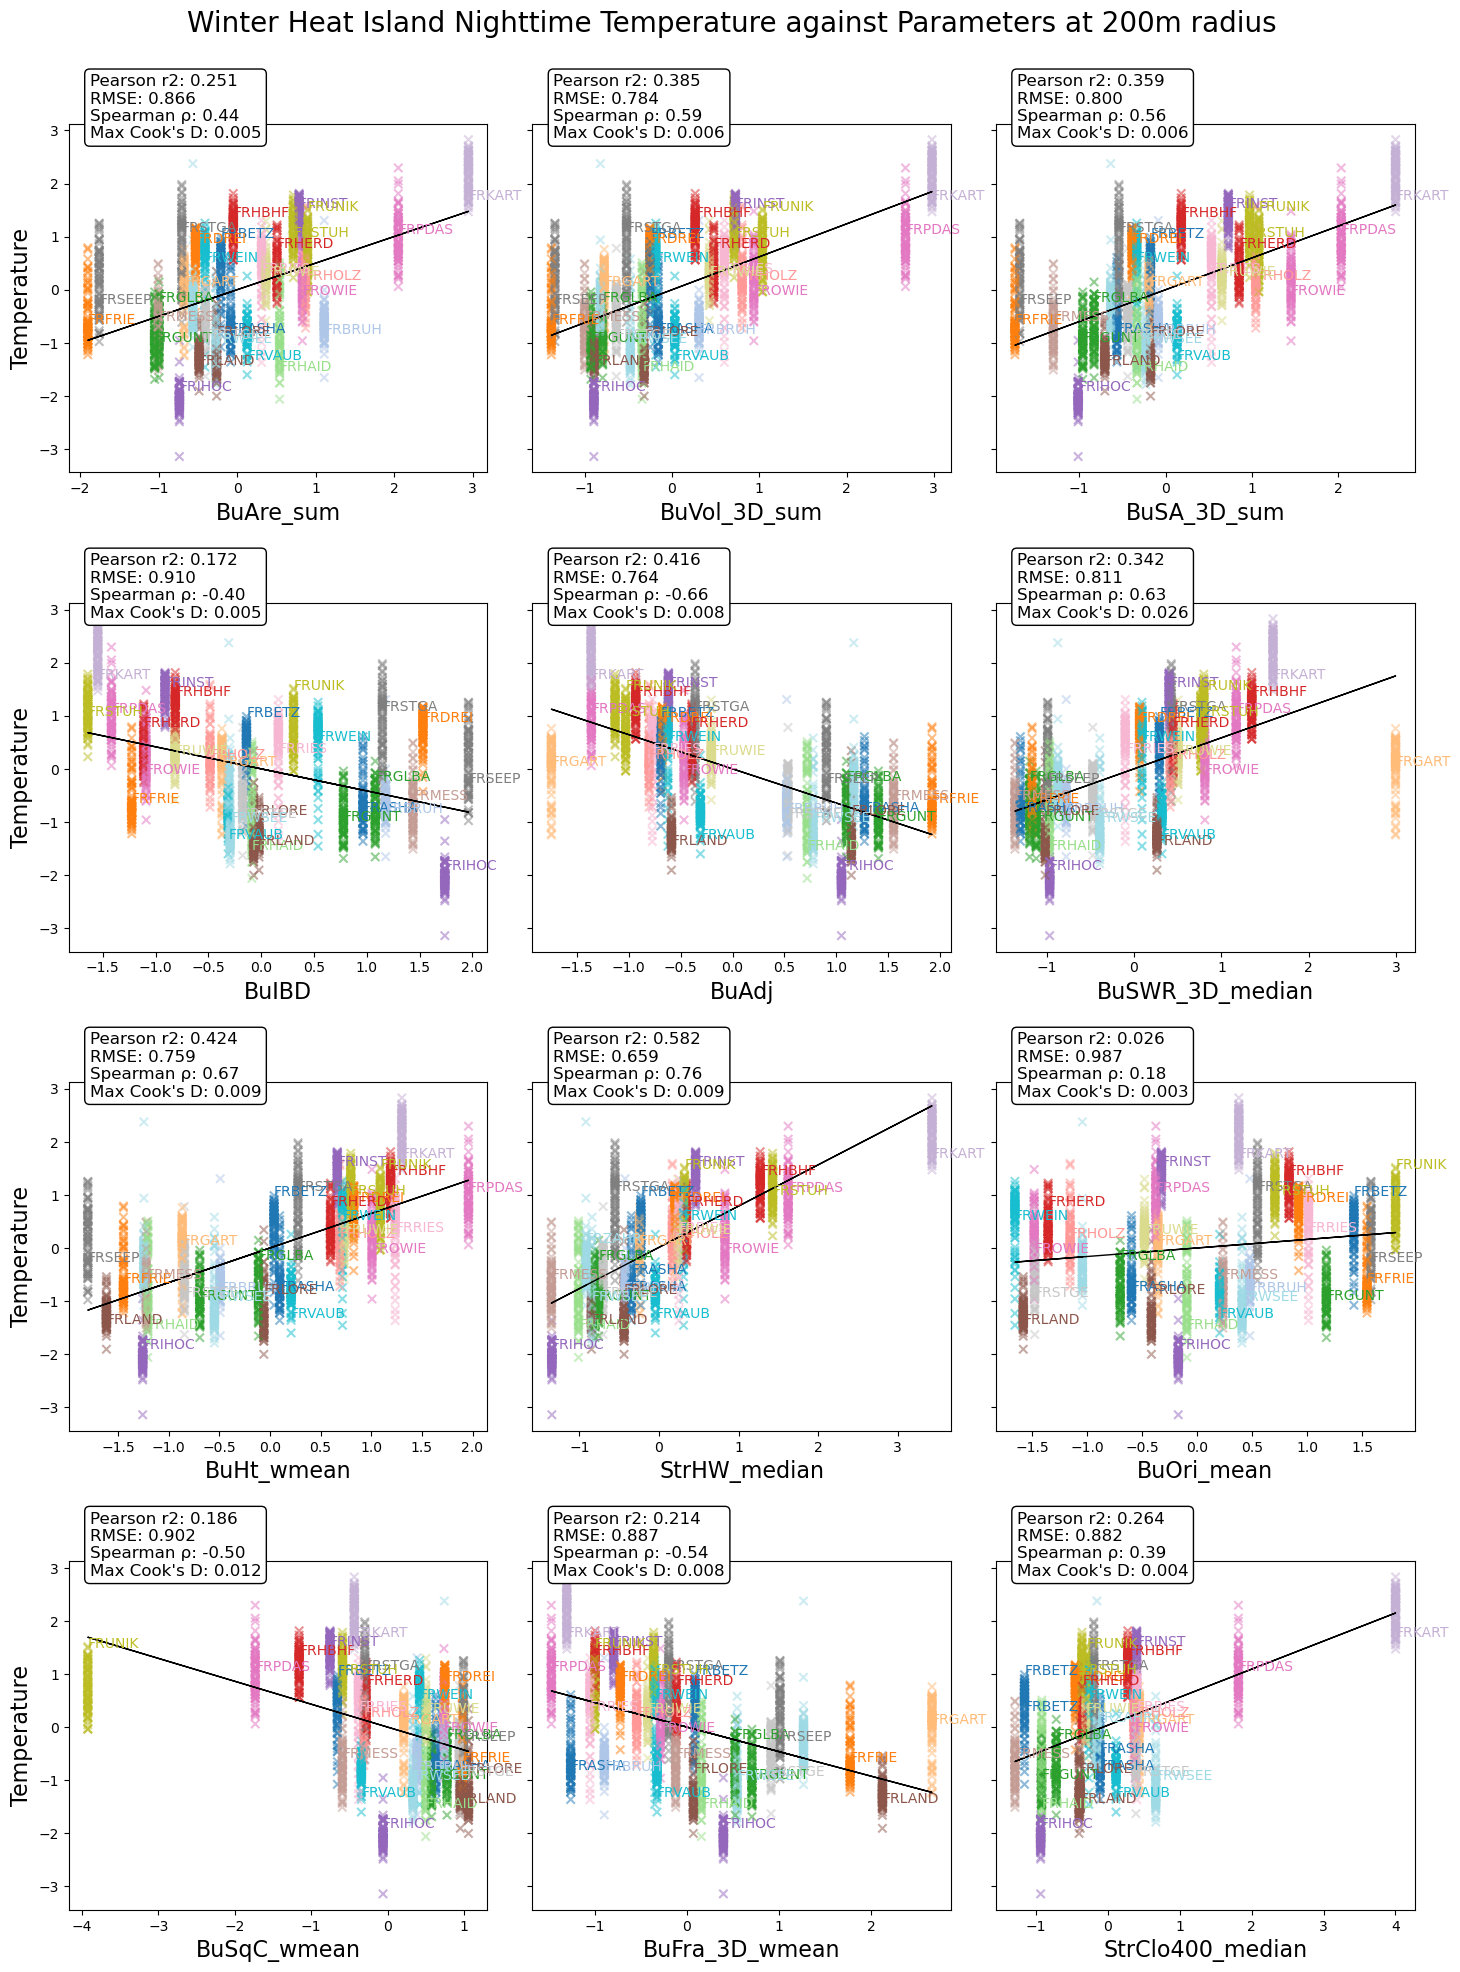

In [54]:
# make 3 by 4 plot with the following parameters
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuSA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','BuOri_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

fig, axs = plt.subplots(4, 3, figsize=(15, 20))
fig.suptitle('Winter Heat Island Nighttime Temperature against Parameters at 200m radius', fontsize=20, y=0.99)
#fig.subplots_adjust(wspace=0.1)
for i, ax in enumerate(axs.flat):
    plot2(ax, 200, params[i], hiwn)

    if i % 3 != 0:  # 1st column (index 0, 3, 6, ...) keeps labels
        ax.set_ylabel("")  # Remove y-axis label
        ax.yaxis.set_ticklabels([])  # Remove y-axis ticks

plt.tight_layout(pad = 2, w_pad=0.01)
plt.savefig('/Users/lisawink/Documents/paper1/figures/hiwn_vs_params_200m.png')
plt.show()

/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/skle

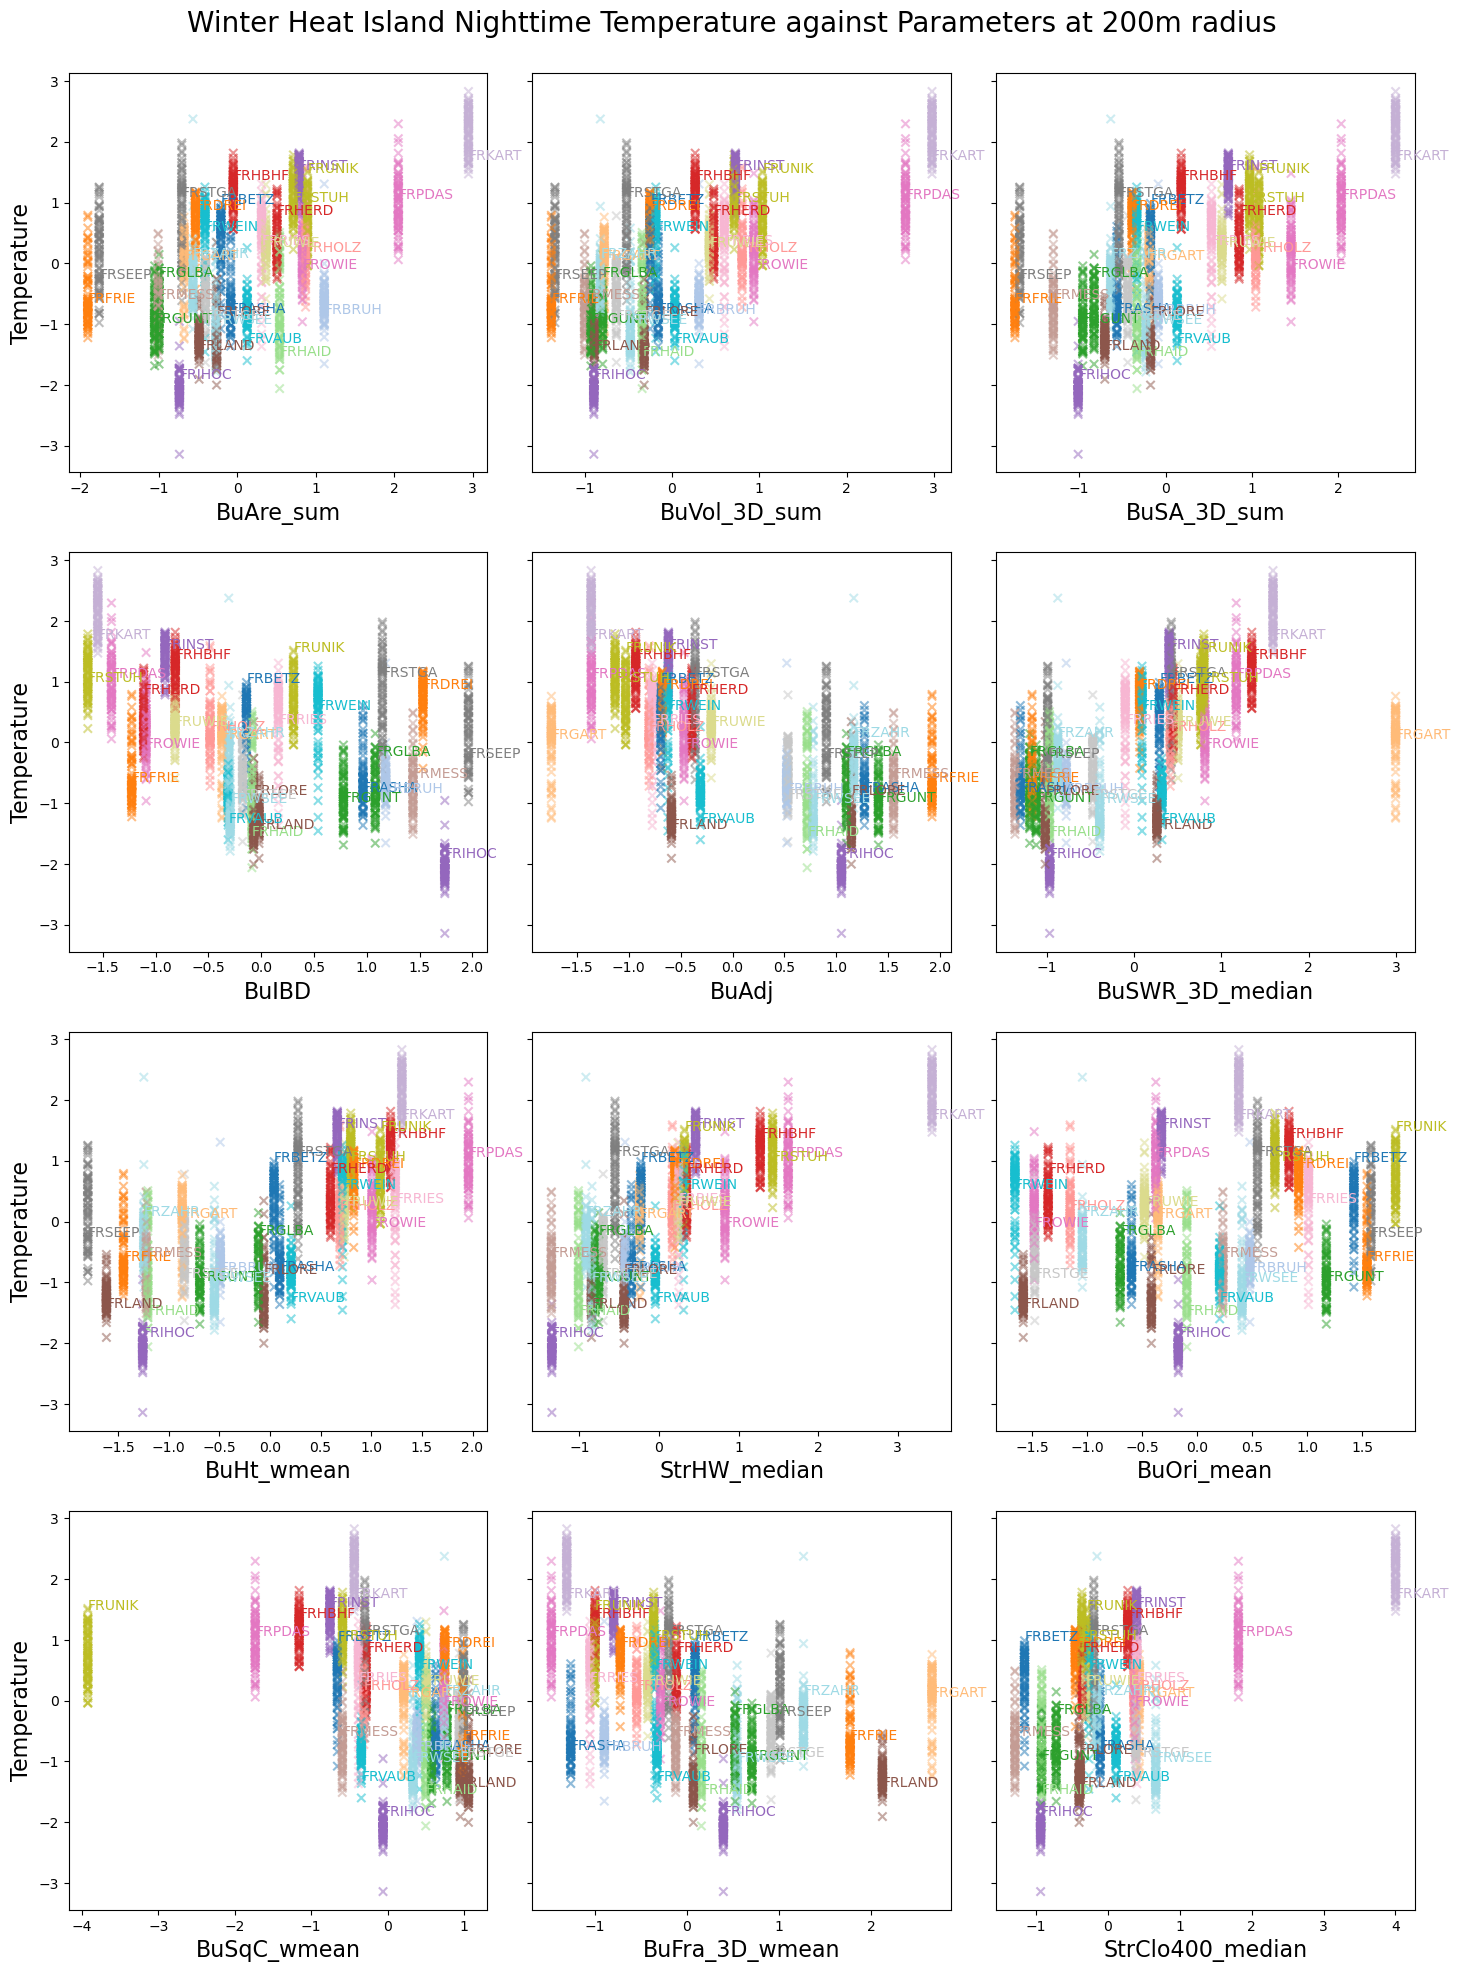

In [103]:
# make 3 by 4 plot with the following parameters
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuSA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','BuOri_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

fig, axs = plt.subplots(4, 3, figsize=(15, 20))
fig.suptitle('Winter Heat Island Nighttime Temperature against Parameters at 200m radius', fontsize=20, y=0.99)
#fig.subplots_adjust(wspace=0.1)
for i, ax in enumerate(axs.flat):
    plot(ax, 200, params[i], hiwn)

    if i % 3 != 0:  # 1st column (index 0, 3, 6, ...) keeps labels
        ax.set_ylabel("")  # Remove y-axis label
        ax.yaxis.set_ticklabels([])  # Remove y-axis ticks

plt.tight_layout(pad = 2, w_pad=0.01)
plt.savefig('/Users/lisawink/Documents/paper1/figures/hiwn_vs_params_200m.png')
plt.show()


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


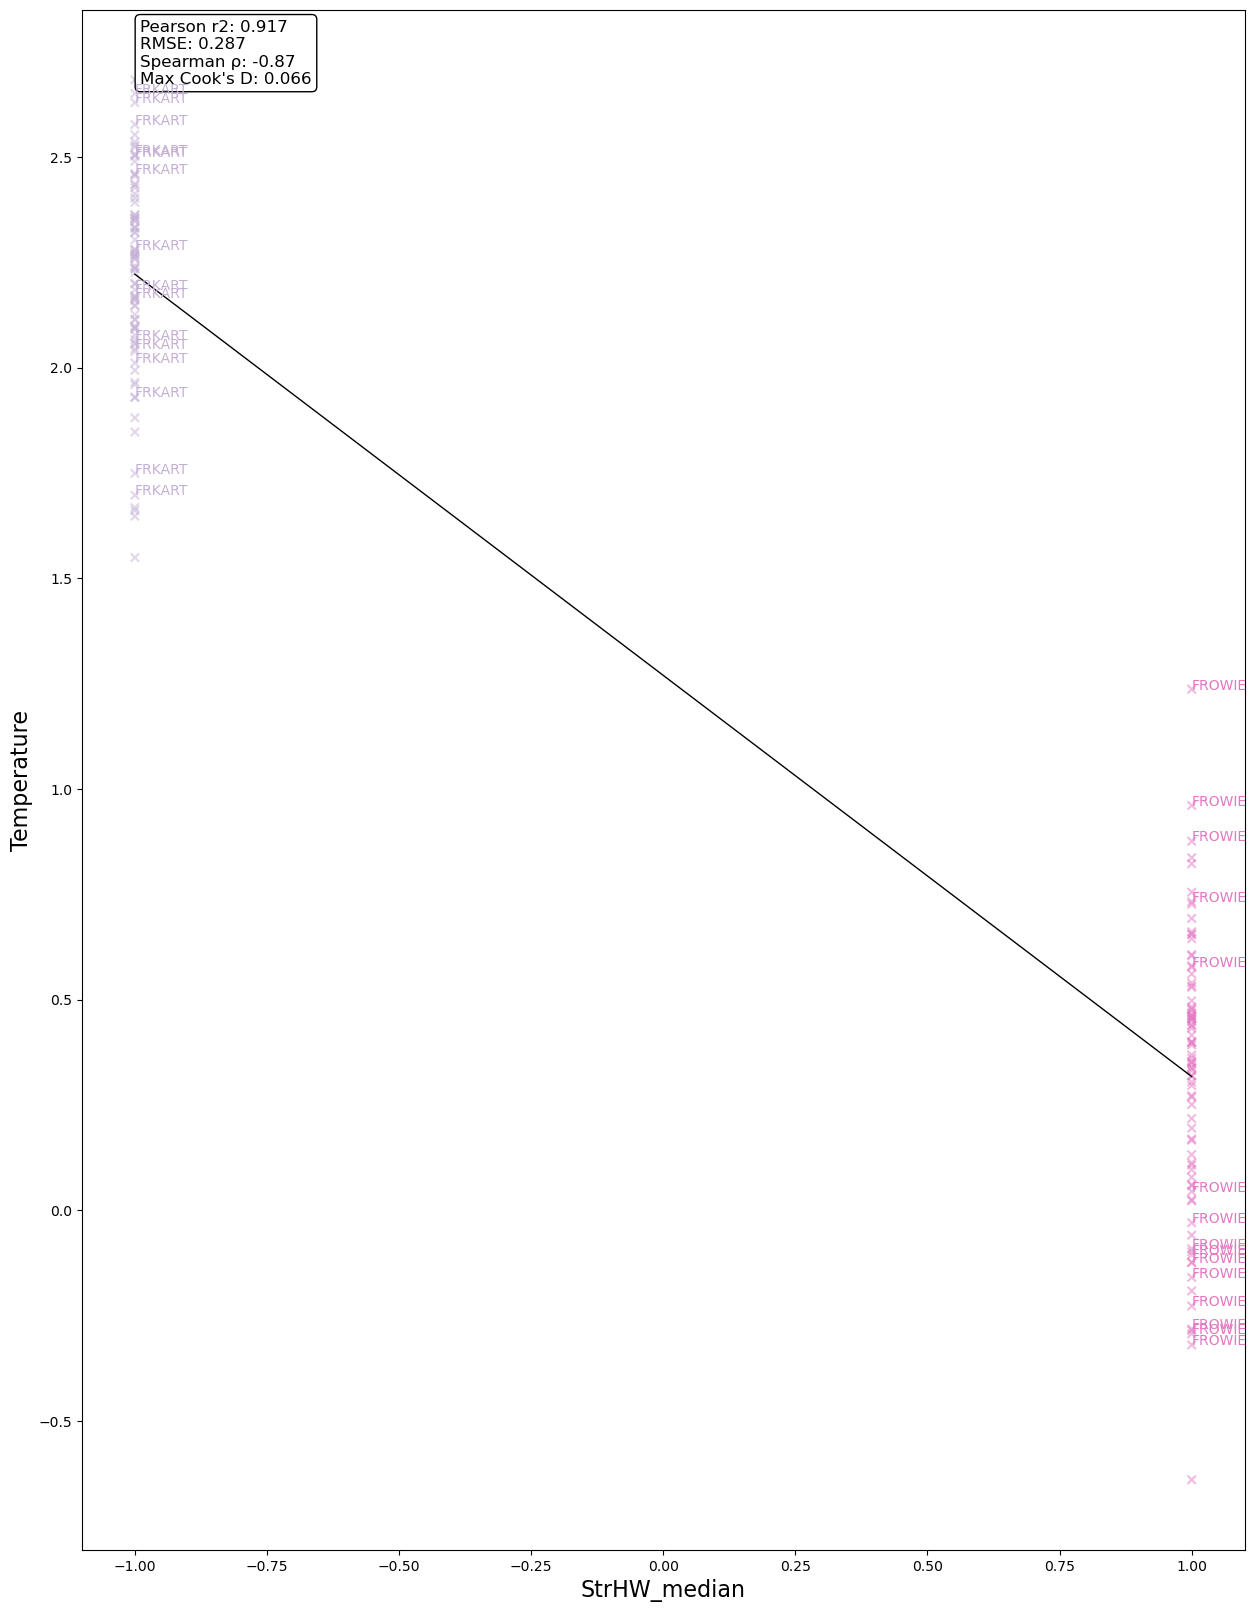

In [62]:
fig, axs = plt.subplots(1,1, figsize=(15, 20))
plot2(axs, 30, 'StrHW_median', hiwn)
plt.show()

/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


TypeError: unhashable type: 'DataFrame'

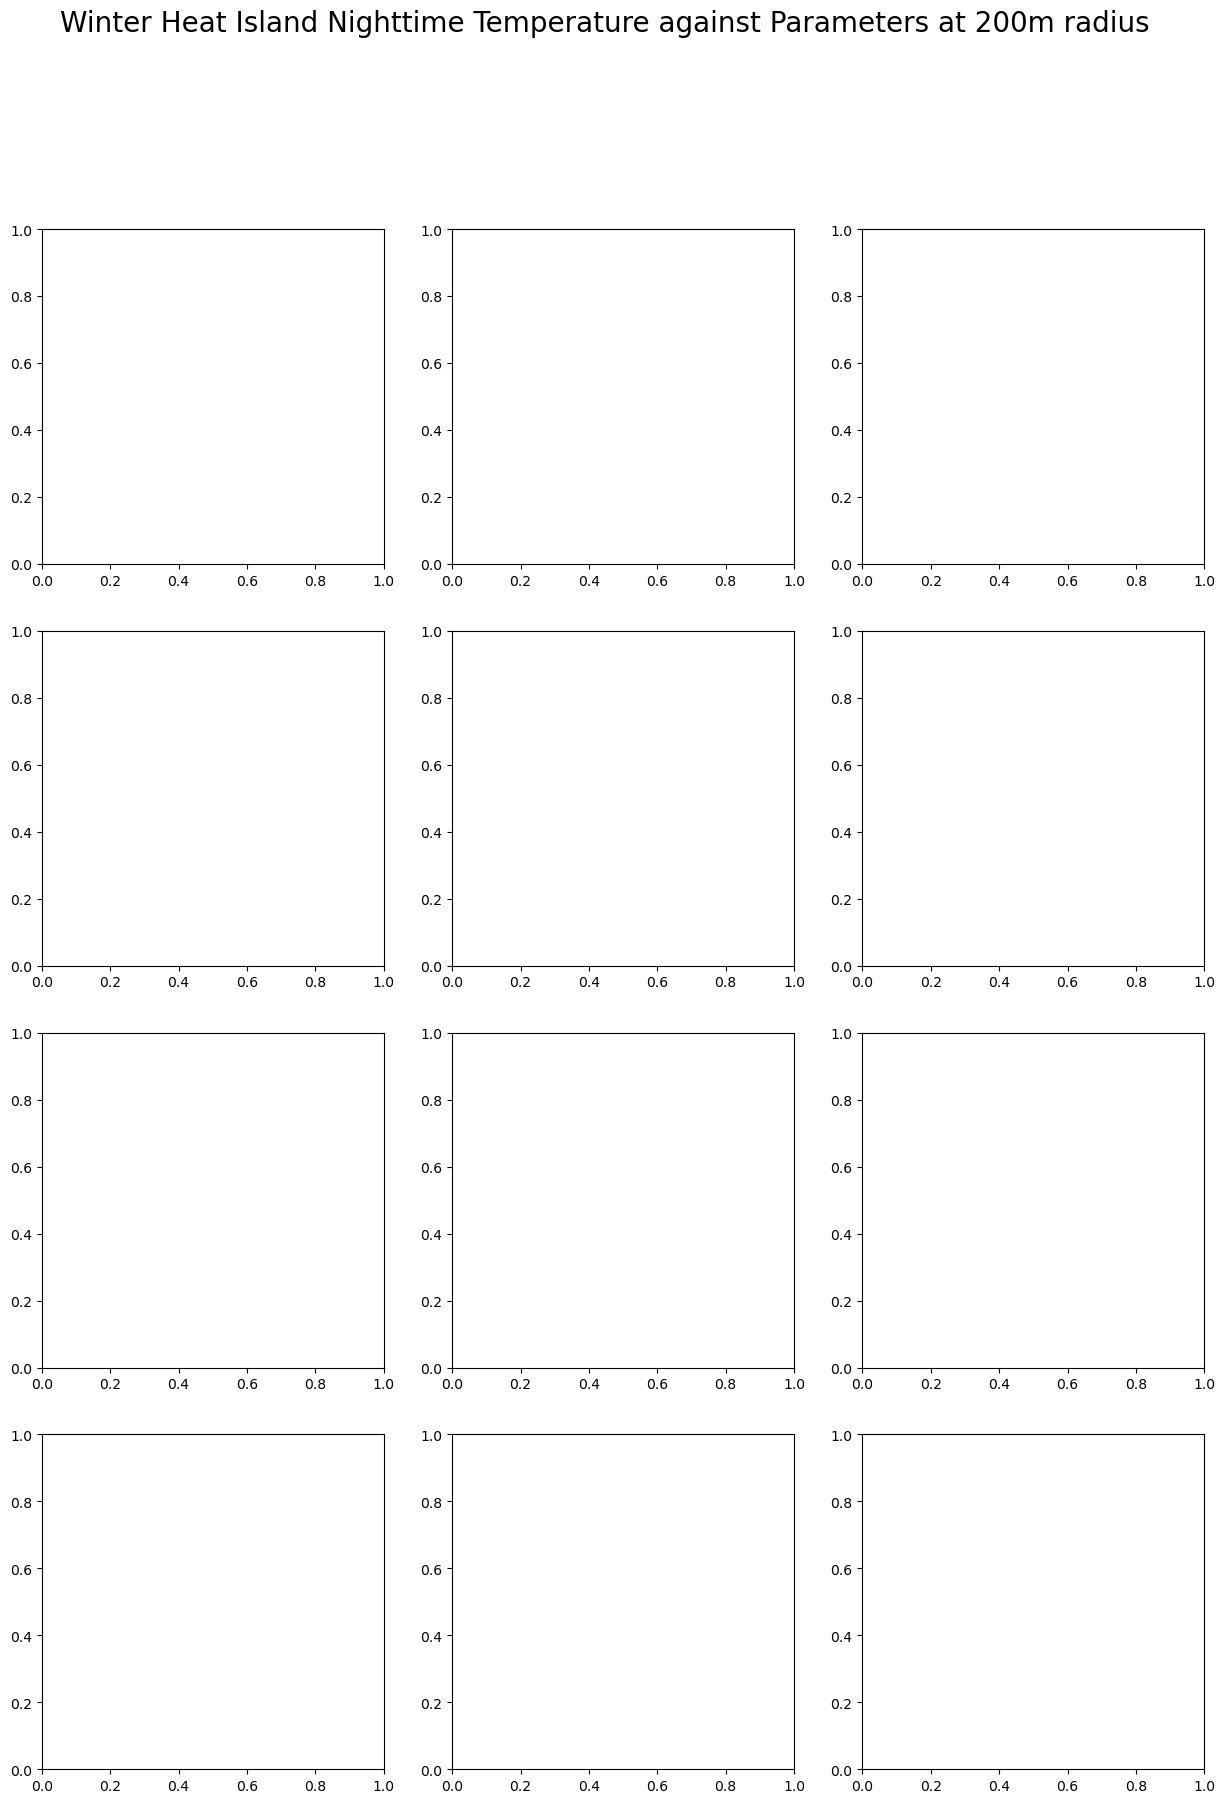

In [56]:
# make 3 by 4 plot with the following parameters
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuSA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','BuOri_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

fig, axs = plt.subplots(4, 3, figsize=(15, 20))
fig.suptitle('Winter Heat Island Nighttime Temperature against Parameters at 200m radius', fontsize=20, y=0.99)
#fig.subplots_adjust(wspace=0.1)
for i, ax in enumerate(axs.flat):
    plot(ax, 30, params[i], hiwn)

    if i % 3 != 0:  # 1st column (index 0, 3, 6, ...) keeps labels
        ax.set_ylabel("")  # Remove y-axis label
        ax.yaxis.set_ticklabels([])  # Remove y-axis ticks

plt.tight_layout(pad = 2, w_pad=0.01)
plt.savefig('/Users/lisawink/Documents/paper1/figures/hiwn_vs_params_30m.png')
plt.show()

/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/lisawink/.conda/envs/py312

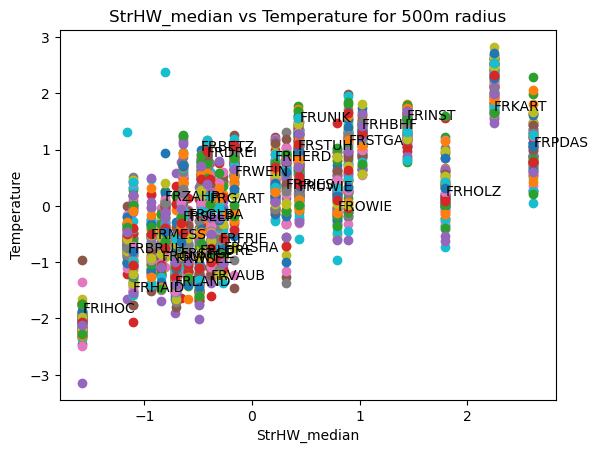

In [59]:
plot(500,'StrHW_median',hiwn)

In [55]:
plot(30,'StrHW_median',hiwn)

TypeError: plot() missing 1 required positional argument: 'time'

/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/lisawink/.conda/envs/py312

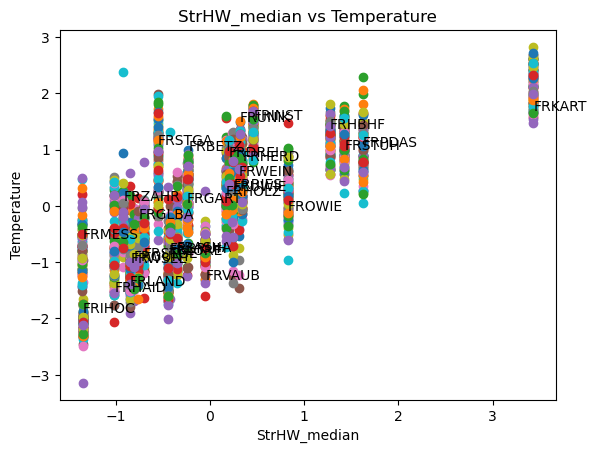

In [54]:
plot(200,'StrHW_median',hiwn)

/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/lisawink/.conda/envs/py312

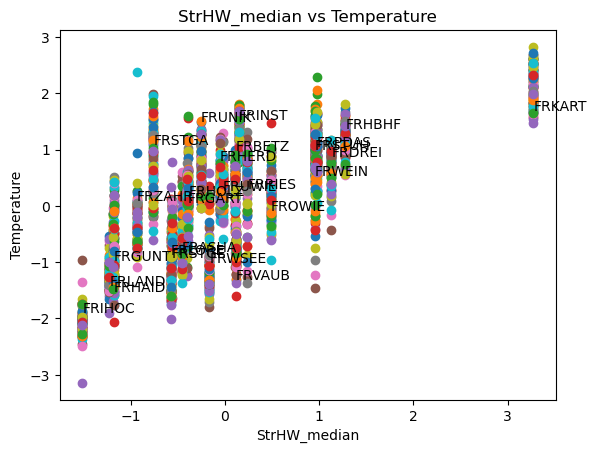

In [55]:
plot(100,'StrHW_median',hiwn)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


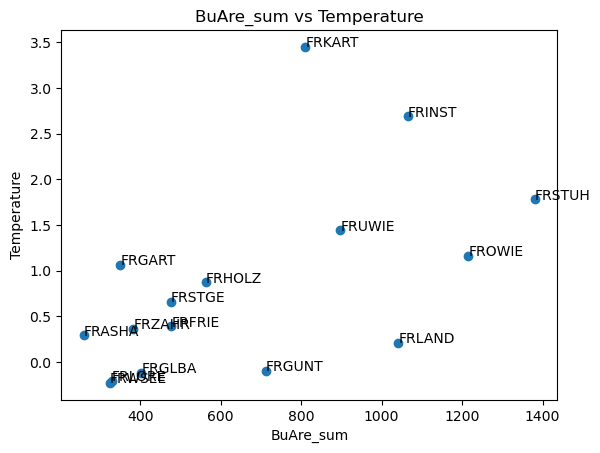

In [14]:
plot(30,'BuAre_sum')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


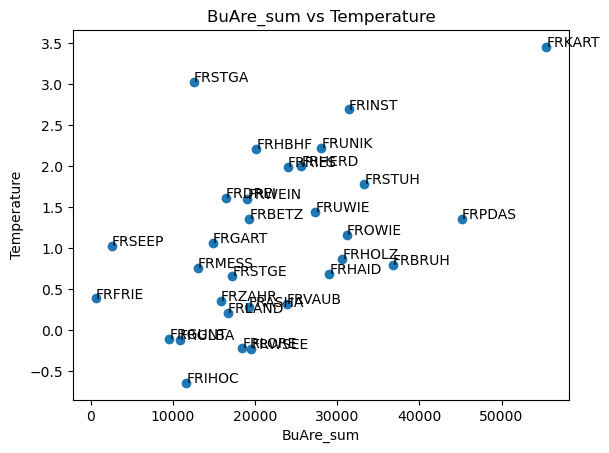

In [15]:
plot(180,'BuAre_sum')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


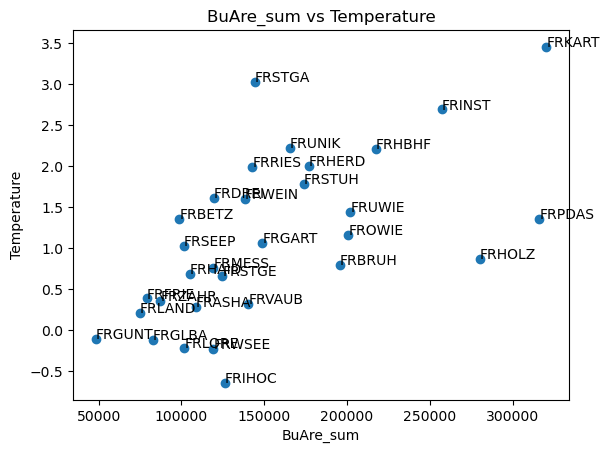

In [18]:
plot(500,'BuAre_sum')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


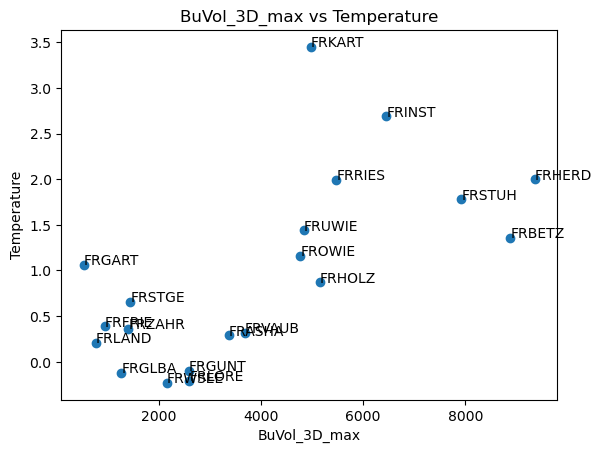

In [19]:
plot(40,'BuVol_3D_max')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


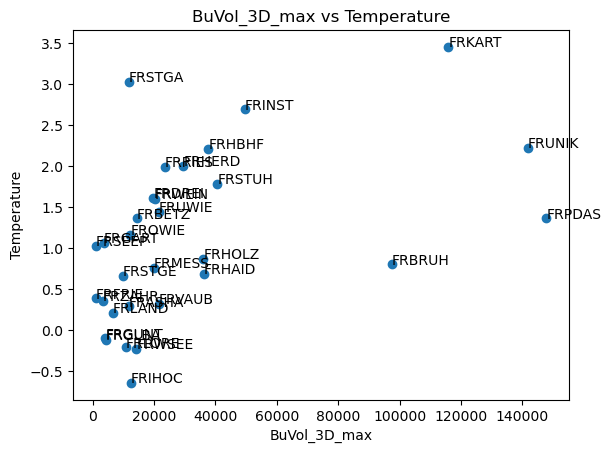

In [20]:
plot(160,'BuVol_3D_max')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


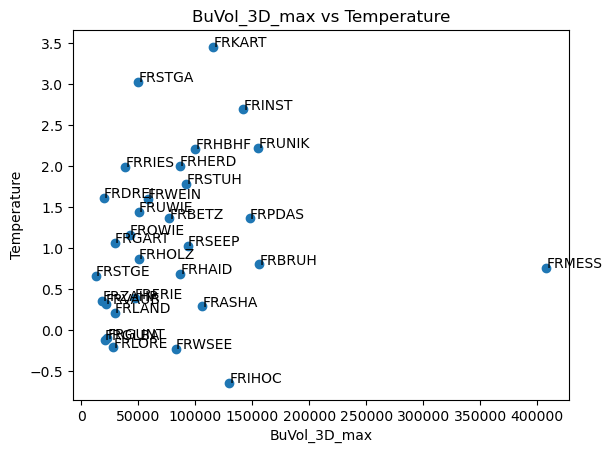

In [21]:
plot(400,'BuVol_3D_max')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


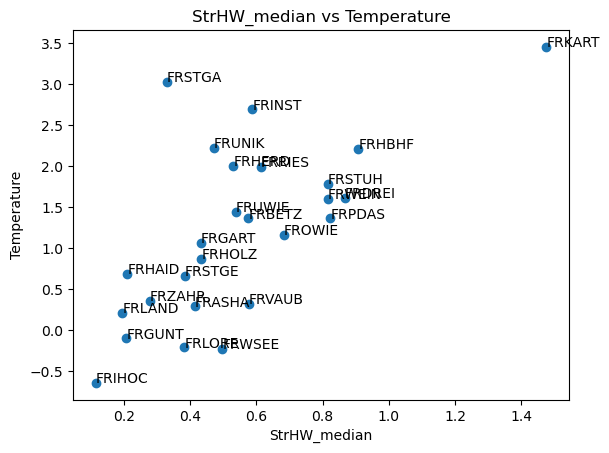

In [27]:
plot(100,'StrHW_median')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


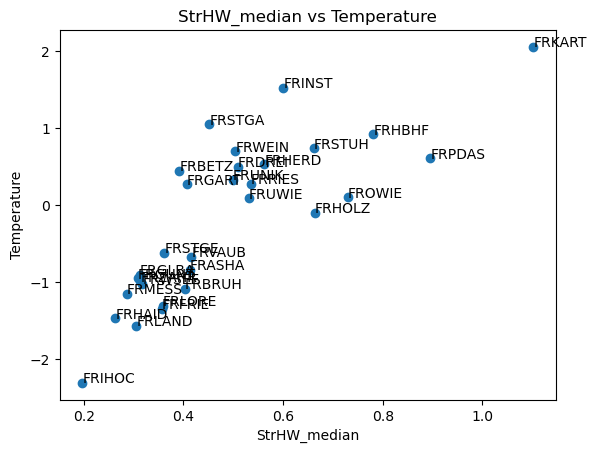

In [8]:
plot(250,'StrHW_median',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


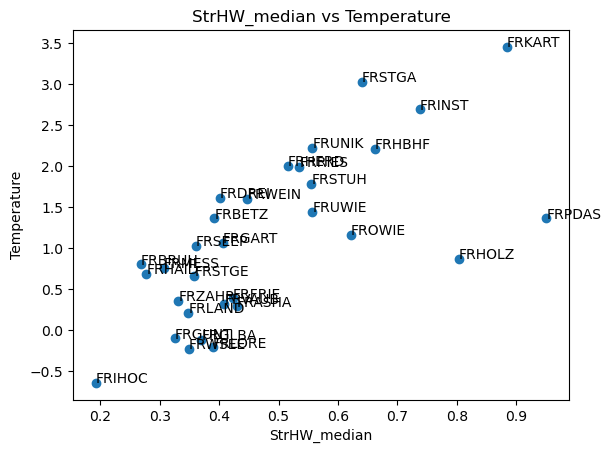

In [23]:
plot(500,'StrHW_median')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


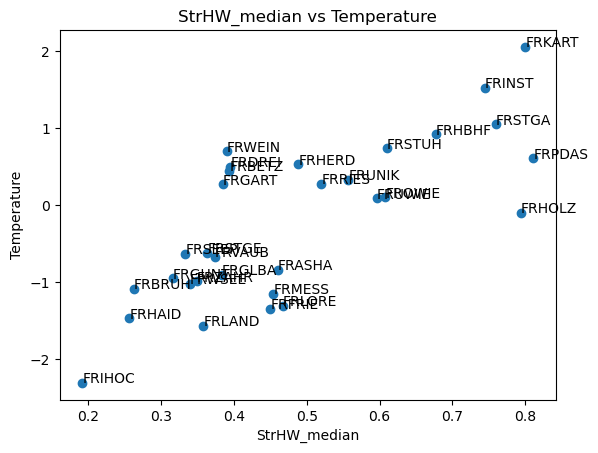

In [7]:
plot(750,'StrHW_median',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


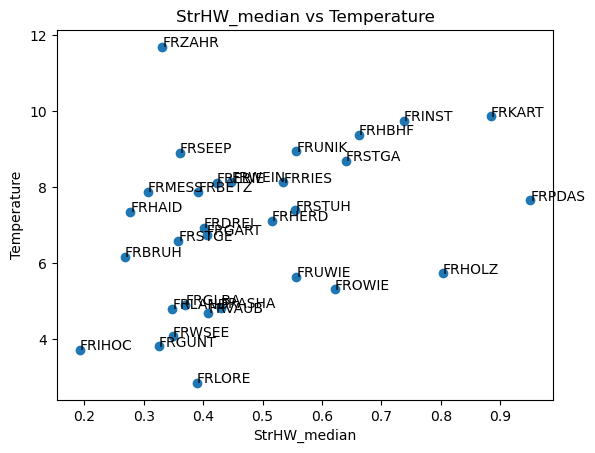

In [29]:
plot(500,'StrHW_median','2022-12-20 03:00:00+00:00')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_79940/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


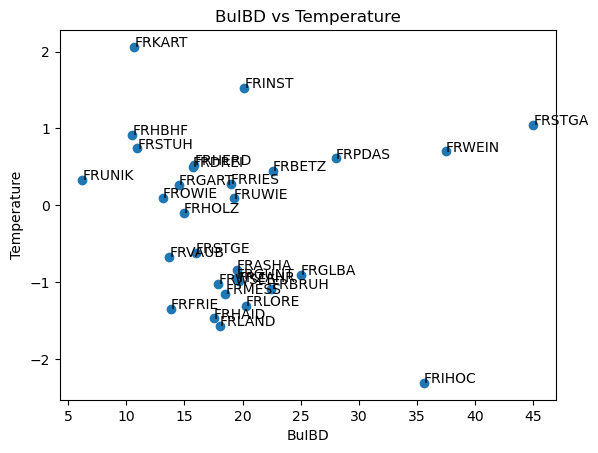

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_79940/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


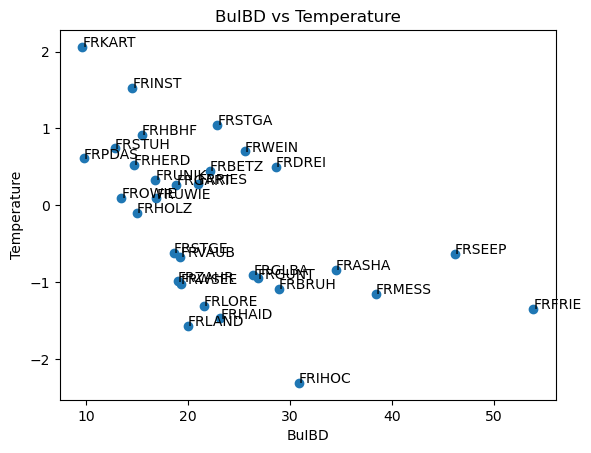

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_79940/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


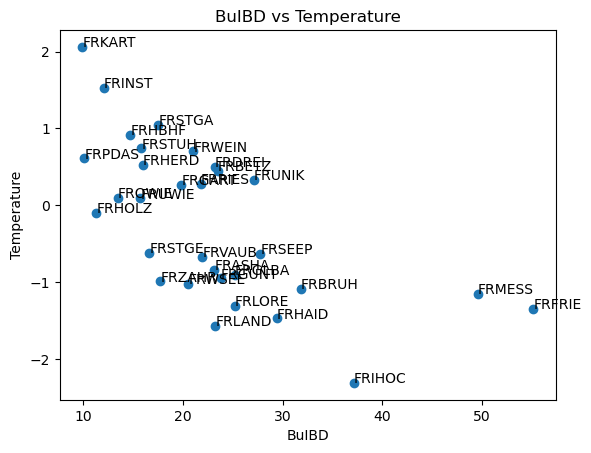

In [14]:
plot(100,'BuIBD',time)
plot(250,'BuIBD',time)
plot(400,'BuIBD',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


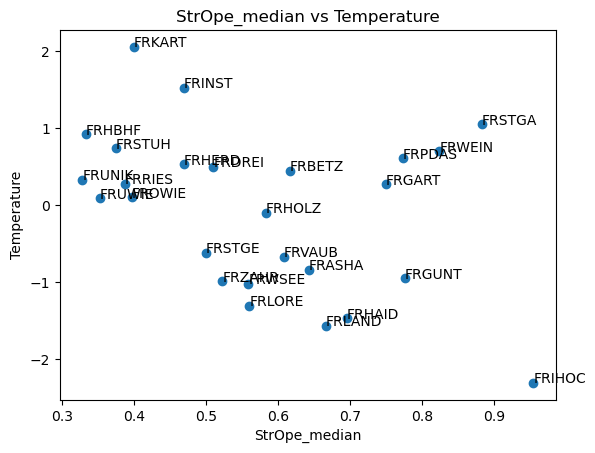

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


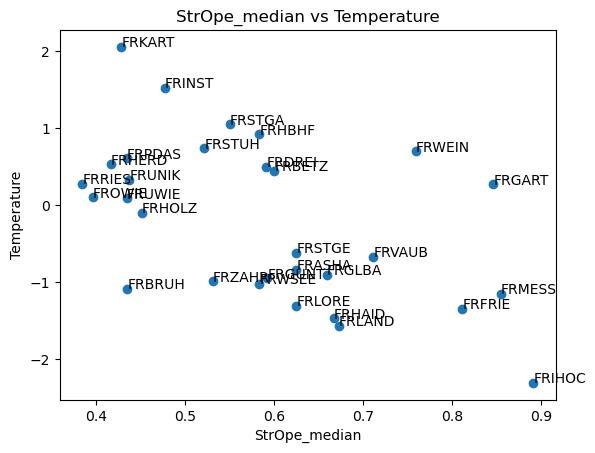

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


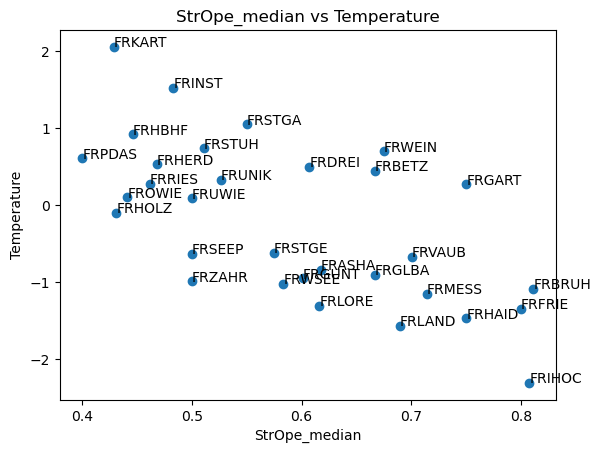

In [10]:
plot(100,'StrOpe_median',time)
plot(250,'StrOpe_median',time)
plot(400,'StrOpe_median',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


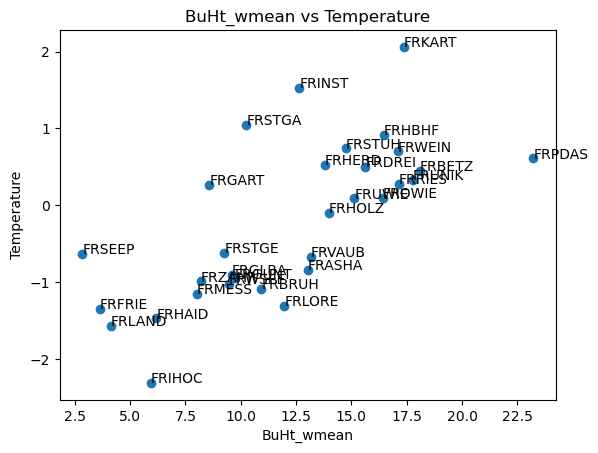

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


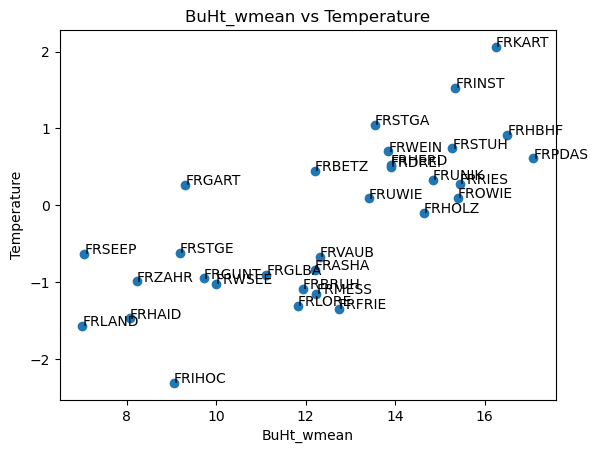

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


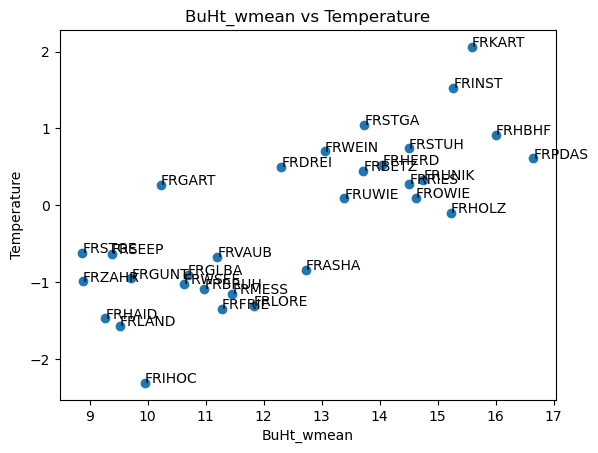

In [11]:
plot(100,'BuHt_wmean',time)
plot(250,'BuHt_wmean',time)
plot(400,'BuHt_wmean',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


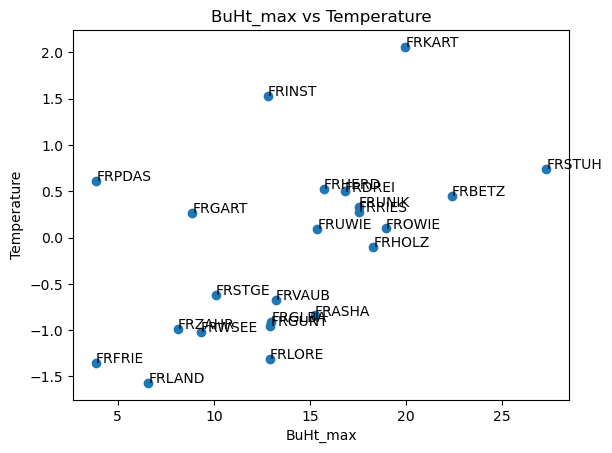

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


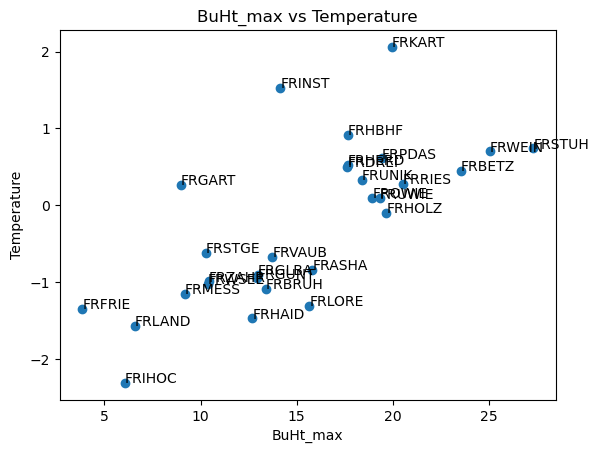

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


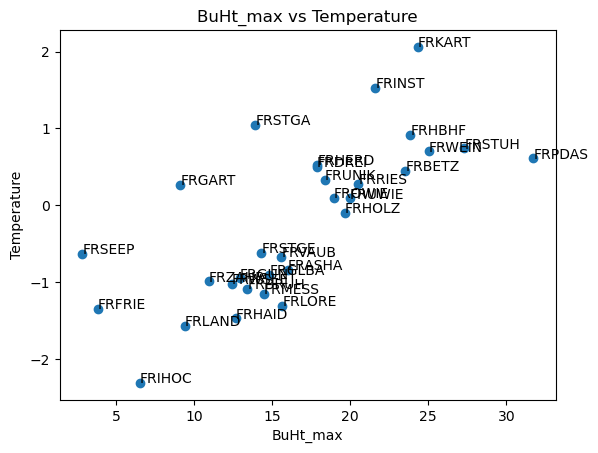

In [13]:
plot(50,'BuHt_max',time)
plot(80,'BuHt_max',time)
plot(100,'BuHt_max',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_79940/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


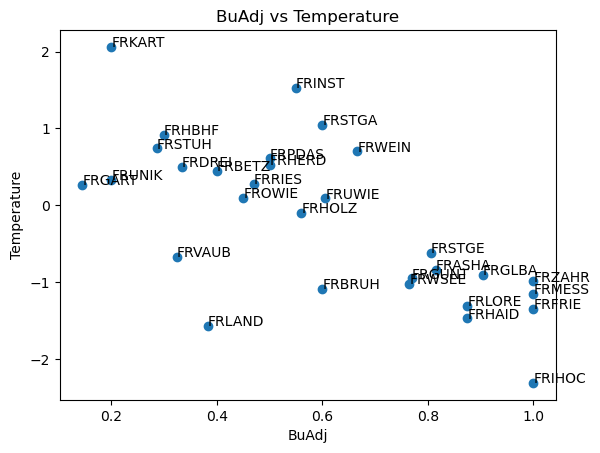

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_79940/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


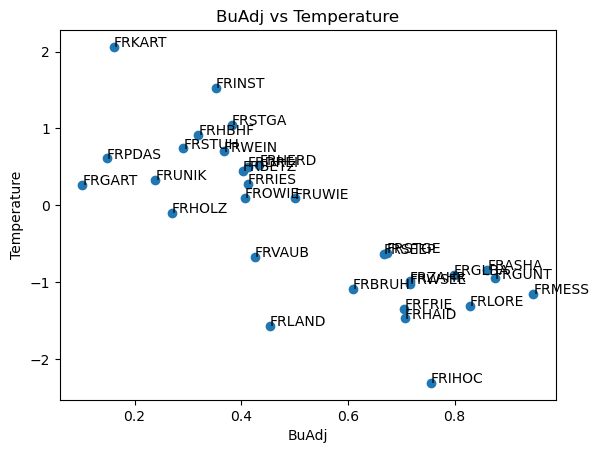

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_79940/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


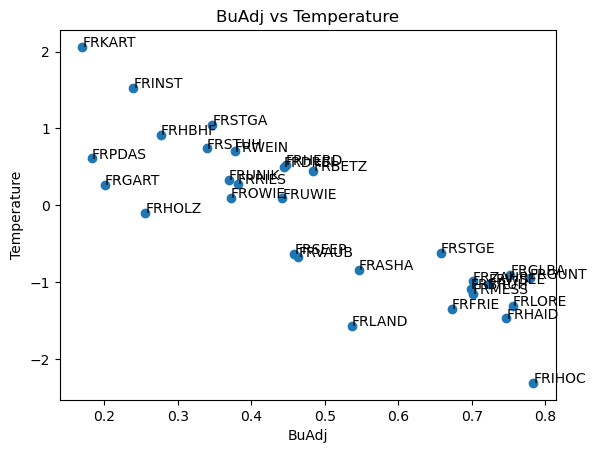

In [15]:
plot(100,'BuAdj',time)
plot(250,'BuAdj',time)
plot(400,'BuAdj',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


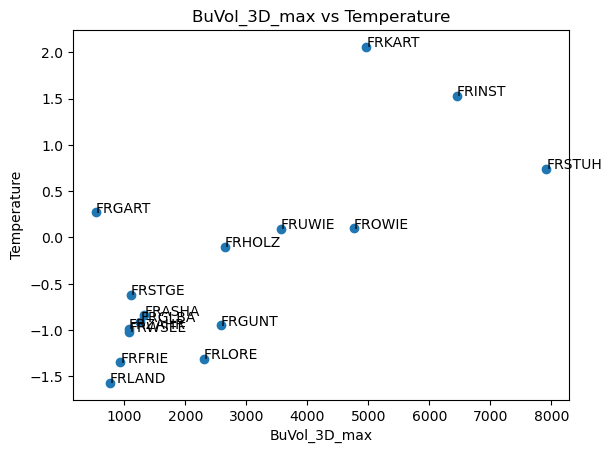

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


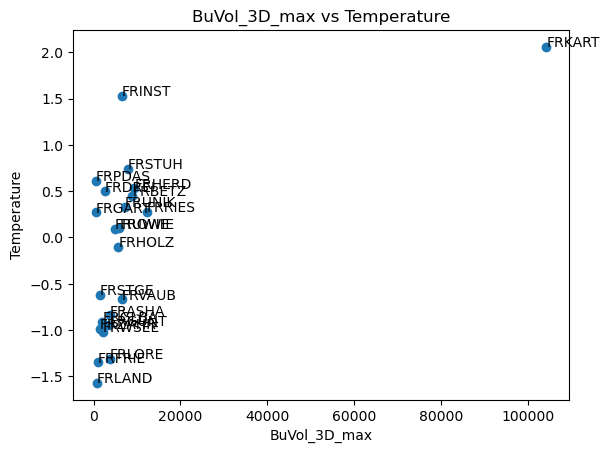

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


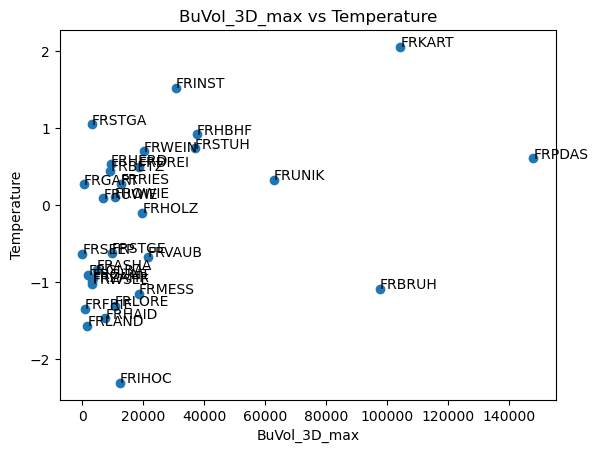

In [17]:
plot(30,'BuVol_3D_max',time)
plot(50,'BuVol_3D_max',time)
plot(100,'BuVol_3D_max',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


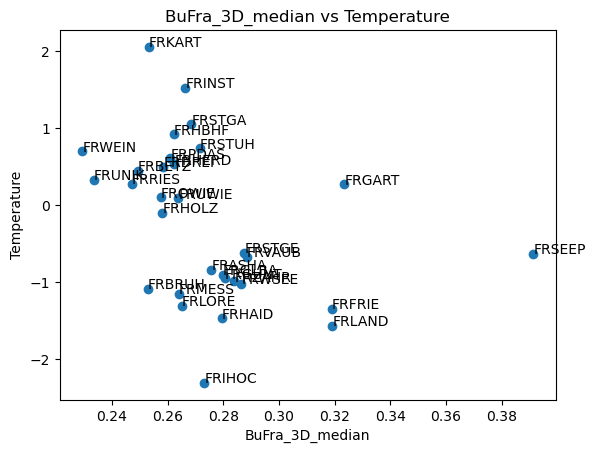

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


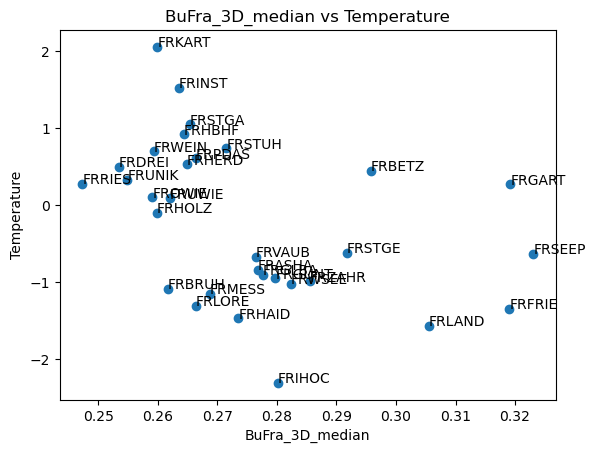

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


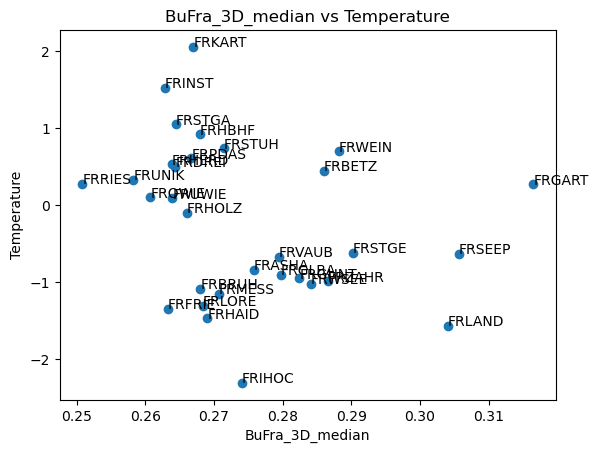

In [23]:
plot(100,'BuFra_3D_median',time)
plot(180,'BuFra_3D_median',time)
plot(300,'BuFra_3D_median',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


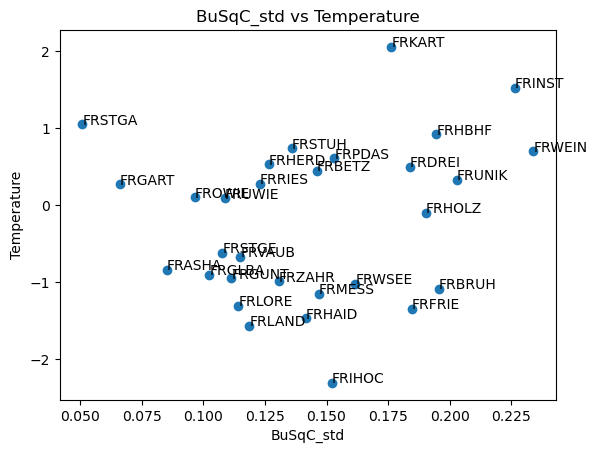

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


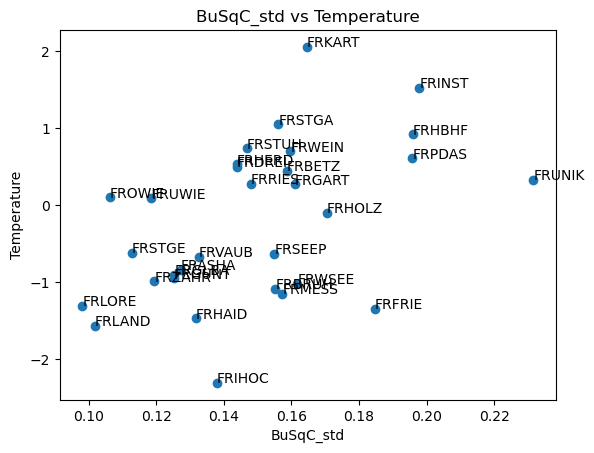

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


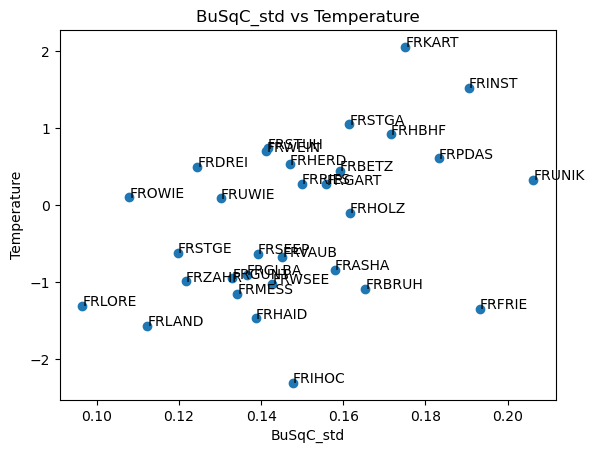

In [22]:
plot(100,'BuSqC_std',time)
plot(180,'BuSqC_std',time)
plot(300,'BuSqC_std',time)

In [11]:
vars = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_70.parquet')
vars.index = vars['station_id']
to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
vars = vars.drop(to_remove, axis=1)
vars = vars.merge(temp[time], left_on='station_id', right_on='station_id',how='inner')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2079826693.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


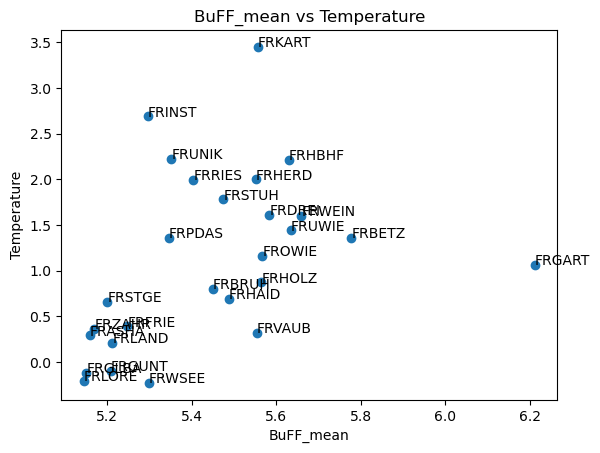

In [12]:
var = 'BuFF_mean'

plt.scatter(vars[var], vars[time])
plt.xlabel(var)
plt.ylabel('Temperature')
plt.title(var+' vs Temperature')

for i, txt in enumerate(vars.index):
    plt.annotate(txt, (vars[var][i], vars[time][i]))


plt.show()

In [8]:
vars = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_160.parquet')
vars.index = vars['station_id']
to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
vars = vars.drop(to_remove, axis=1)
vars = vars.merge(temp[time], left_on='station_id', right_on='station_id',how='inner')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2079826693.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


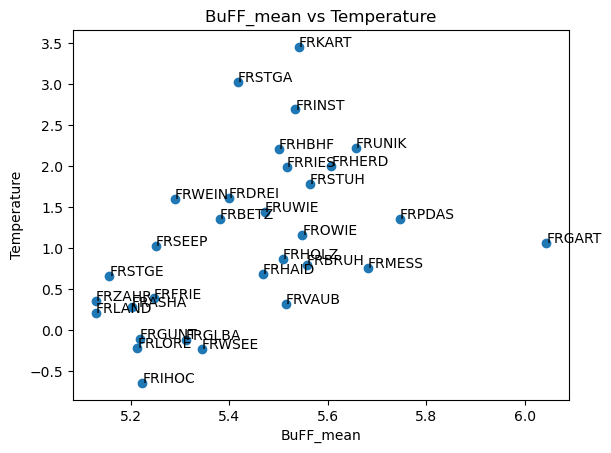

In [10]:
var = 'BuFF_mean'

plt.scatter(vars[var], vars[time])
plt.xlabel(var)
plt.ylabel('Temperature')
plt.title(var+' vs Temperature')

for i, txt in enumerate(vars.index):
    plt.annotate(txt, (vars[var][i], vars[time][i]))


plt.show()

In [ ]:
vars = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_30.parquet')
vars.index = vars['station_id']
to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
vars = vars.drop(to_remove, axis=1)
vars = vars.merge(temp[time], left_on='station_id', right_on='station_id',how='inner')